In [1]:
import math
import random
import pandas as pd
import numpy as np
import numpy.matlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import collections
import phenograph
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

In [2]:
def combine_dup_genes(adata):
    # Combines duplicated variable names into one
    dup_genes = [item for item, count in collections.Counter(adata.var.index).items() if count > 1]
    new_cols = []
    for g in dup_genes:
        # index of dup genes
        idy = adata.var.index == g
        # index of all remaining genes
        new_idy = adata.var.index != g
        temp_df = pd.DataFrame(adata[:, idy].X, index =adata[:, idy].obs.index)
        temp_df = temp_df.sum(axis = 1)
        new_cols.append(temp_df)
        adata = adata[:, new_idy]
    
    fixed_genes_df = pd.DataFrame(new_cols, index = dup_genes).T
    fixed_genes_adata = anndata.AnnData(fixed_genes_df)
    return anndata.concat([adata, fixed_genes_adata], axis = 1)
    
def load_layer(path):
    X = pd.read_csv(path, delimiter='\t').T
    adata = anndata.AnnData(X = X)
    print("Combining duplicate genes")
    adata = combine_dup_genes(adata)
    coor = []
    for c in X.index:
        coor.append([float(x) for x in c.split('_')])
    adata.obsm['spatial'] = np.array(coor)
    return adata

## Data Processing and Visualization

### Online Viewer: https://als-st.nygenome.org/array_human

In [3]:
adata_c1 = load_layer('../data/spinal/L8CN11_E1_stdata_aligned_counts_IDs.txt')
labels_df = pd.read_csv('../data/spinal/L8CN11_E1.tsv.annotations.tsv', delimiter='\t')
labels_df.drop(labels_df.columns[[0, 1, 2, 3]], axis=1, inplace = True)
adata_c1.obs['anno'] = list(labels_df.idxmax(axis = 1))

adata_c2 = load_layer('../data/spinal/L8CN11_E2_stdata_aligned_counts_IDs.txt')
labels_df = pd.read_csv('../data/spinal/L8CN11_E2.tsv.annotations.tsv', delimiter='\t')
labels_df.drop(labels_df.columns[[0, 1, 2, 3]], axis=1, inplace = True)
adata_c2.obs['anno'] = list(labels_df.idxmax(axis = 1))

adata_c1.layers['raw_counts'] = adata_c1.X.copy()
sc.pp.normalize_total(adata_c1, inplace= True)
adata_c1.X = np.log2(np.array(adata_c1.X) + 0.1) - np.log2(0.1)
zdf = StandardScaler().fit_transform(adata_c1.X)
adata_c1.layers['zscore'] = zdf

adata_c2.layers['raw_counts'] = adata_c2.X.copy()
sc.pp.normalize_total(adata_c2, inplace= True)
adata_c2.X = np.log2(np.array(adata_c2.X) + 0.1) - np.log2(0.1)
zdf = StandardScaler().fit_transform(adata_c2.X)
adata_c2.layers['zscore'] = zdf

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Combining duplicate genes


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Combining duplicate genes


In [4]:
annotations = np.unique(labels_df.columns)
c_pal = dict(zip(annotations, sns.color_palette("Paired")[:len(annotations)] + ['#000000']))

### Plot spatial

... storing 'anno' as categorical


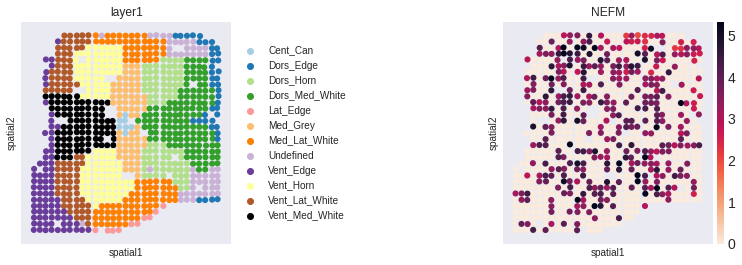

In [5]:
sc.pl.spatial(adata_c1, spot_size=1, color = ['anno', 'NEFM'], 
              vmin = 'p1', vmax = 'p99', title = 'layer1', 
              palette= c_pal, cmap = 'rocket_r')

... storing 'anno' as categorical


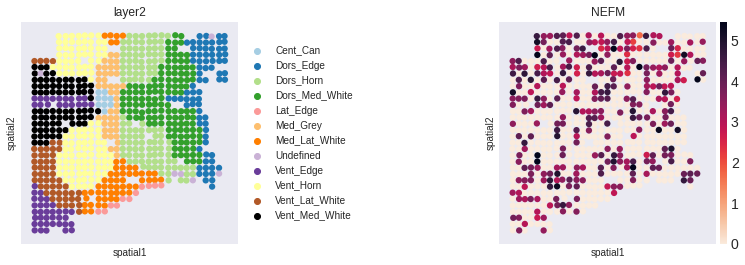

In [6]:
sc.pl.spatial(adata_c2, spot_size=1, color = ['anno', 'NEFM'],  
              vmin = 'p1', vmax = 'p99', title = 'layer2', 
              palette=c_pal, cmap = 'rocket_r')

#### Relabel Vent_Horn and Dors_Horn 1 and 2

Figure out the Y cutoff the to split into two groups.

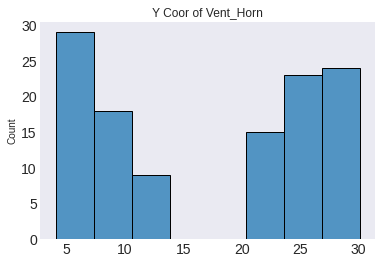

[Text(0.5, 1.0, 'Y Coor of Dors_Horn')]

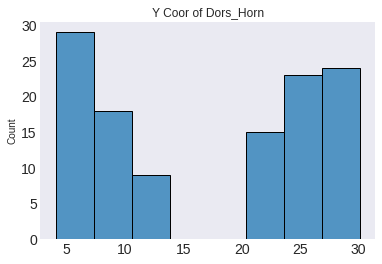

In [5]:
idx = adata_c1.obs['anno'] == 'Vent_Horn'

g = sns.histplot(adata_c1[idx, :].obsm['spatial'][:, 1])
g.set(title = 'Y Coor of Vent_Horn')
plt.show()

idx_2 = adata_c1.obs['anno'] == 'Dors_Horn'

g1 = sns.histplot(adata_c1[idx, :].obsm['spatial'][:, 1])
g1.set(title = 'Y Coor of Dors_Horn')

... storing 'anno' as categorical
... storing 'anno_v2' as categorical


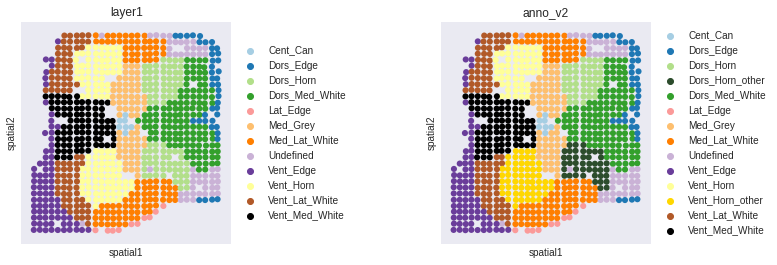

In [6]:
anno_v2 = list(adata_c1.obs['anno'])

for i in range(len(anno_v2)):
    if idx[i]:
        if adata_c1.obsm['spatial'][i, 1] > 17:
            anno_v2[i] = anno_v2[i] + '_other'
    if idx_2[i]:
        if adata_c1.obsm['spatial'][i, 1] > 17:
            anno_v2[i] = anno_v2[i] + '_other'

adata_c1.obs['anno_v2'] = anno_v2
c_pal_v2 = c_pal.copy()
c_pal_v2['Vent_Horn_other'] = '#FFD700'
c_pal_v2['Dors_Horn_other'] = '#2c4c2c'

sc.pl.spatial(adata_c1, spot_size=1, color = ['anno', 'anno_v2'], 
              vmin = 'p1', vmax = 'p99', title = 'layer1', 
              palette= c_pal_v2, cmap = 'rocket_r')

Repeat for layer 2

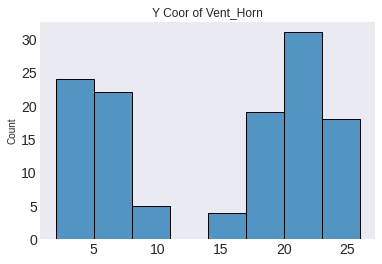

[Text(0.5, 1.0, 'Y Coor of Dors_Horn')]

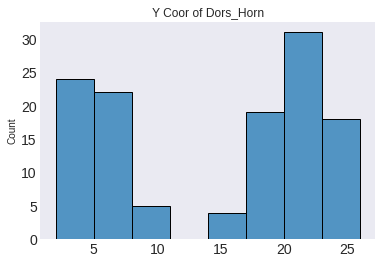

In [7]:
idx = adata_c2.obs['anno'] == 'Vent_Horn'

g = sns.histplot(adata_c2[idx, :].obsm['spatial'][:, 1])
g.set(title = 'Y Coor of Vent_Horn')
plt.show()

idx_2 = adata_c2.obs['anno'] == 'Dors_Horn'

g1 = sns.histplot(adata_c2[idx, :].obsm['spatial'][:, 1])
g1.set(title = 'Y Coor of Dors_Horn')

... storing 'anno' as categorical
... storing 'anno_v2' as categorical


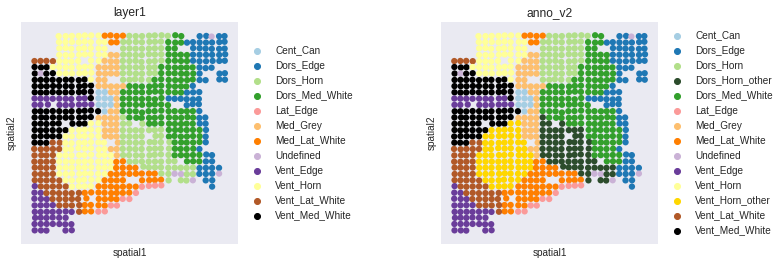

In [8]:
anno_v2 = list(adata_c2.obs['anno'])

for i in range(len(anno_v2)):
    if idx[i]:
        if adata_c2.obsm['spatial'][i, 1] > 13:
            anno_v2[i] = anno_v2[i] + '_other'
    if idx_2[i]:
        if adata_c2.obsm['spatial'][i, 1] > 13:
            anno_v2[i] = anno_v2[i] + '_other'

adata_c2.obs['anno_v2'] = anno_v2
c_pal_v2 = c_pal.copy()
c_pal_v2['Vent_Horn_other'] = '#FFD700'
c_pal_v2['Dors_Horn_other'] = '#2c4c2c'

sc.pl.spatial(adata_c2, spot_size=1, color = ['anno', 'anno_v2'], 
              vmin = 'p1', vmax = 'p99', title = 'layer1', 
              palette= c_pal_v2, cmap = 'rocket_r')

### Center Align

In [116]:
slices = [adata_c1.copy(), adata_c2.copy()]
lmbda = len(slices)*[1/len(slices)]
center_slice, pis = paste.center_align(slices[0], slices, lmbda, random_seed = 5, alpha = 0.001)

Filtered all slices for common genes. There are 16427 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 16427 common genes.
Filtered all slices for common genes. There are 16427 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.5234187259728458

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 16427 common genes.
Filtered all slices for common genes. There are 16427 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.04112358025715879

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 16427 common genes.
Filtered all slices for common genes. There are 16427 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.00016827590430579242



In [117]:
# center_slice = sc.read_h5ad('./cache/spinal_data/L8CN11_center.h5ad')
sc.pp.normalize_total(center_slice, inplace= True)
center_slice.X = np.log2(np.array(center_slice.X) + 0.1) - np.log2(0.1)
zdf = StandardScaler().fit_transform(center_slice.X)
center_slice.layers['zscore'] = zdf

... storing 'anno' as categorical


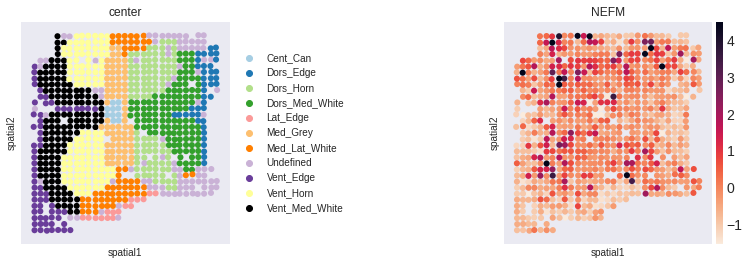

In [118]:
sc.pl.spatial(center_slice, spot_size=1, color = ['anno', 'NEFM'], 
              vmin = 'p1', vmax = 'p99', title = 'center', 
              palette=c_pal, cmap= 'rocket_r', layer='zscore')

## Evaluate PASTE

Read in data and relabel Vent_horn and Dors_Horn as done above. Save as a function for convenience.

In [16]:
def read_in_data():
    adata_c1 = load_layer('../data/spinal/L8CN11_E1_stdata_aligned_counts_IDs.txt')
    labels_df = pd.read_csv('../data/spinal/L8CN11_E1.tsv.annotations.tsv', delimiter='\t')
    labels_df.drop(labels_df.columns[[0, 1, 2, 3]], axis=1, inplace = True)
    adata_c1.obs['anno'] = list(labels_df.idxmax(axis = 1))

    adata_c2 = load_layer('../data/spinal/L8CN11_E2_stdata_aligned_counts_IDs.txt')
    labels_df = pd.read_csv('../data/spinal/L8CN11_E2.tsv.annotations.tsv', delimiter='\t')
    labels_df.drop(labels_df.columns[[0, 1, 2, 3]], axis=1, inplace = True)
    adata_c2.obs['anno'] = list(labels_df.idxmax(axis = 1))

    idx = adata_c1.obs['anno'] == 'Vent_Horn'
    idx_2 = adata_c1.obs['anno'] == 'Dors_Horn'
    anno_v2 = list(adata_c1.obs['anno'])
    for i in range(len(anno_v2)):
        if idx[i]:
            if adata_c1.obsm['spatial'][i, 1] > 17:
                anno_v2[i] = anno_v2[i] + '_other'
        if idx_2[i]:
            if adata_c1.obsm['spatial'][i, 1] > 17:
                anno_v2[i] = anno_v2[i] + '_other'
    adata_c1.obs['anno_v2'] = anno_v2
    c_pal_v2 = c_pal.copy()
    c_pal_v2['Vent_Horn_other'] = '#FFD700'
    c_pal_v2['Dors_Horn_other'] = '#2c4c2c'

    idx = adata_c2.obs['anno'] == 'Vent_Horn'
    idx_2 = adata_c2.obs['anno'] == 'Dors_Horn'
    anno_v2 = list(adata_c2.obs['anno'])
    for i in range(len(anno_v2)):
        if idx[i]:
            if adata_c2.obsm['spatial'][i, 1] > 13:
                anno_v2[i] = anno_v2[i] + '_other'
        if idx_2[i]:
            if adata_c2.obsm['spatial'][i, 1] > 13:
                anno_v2[i] = anno_v2[i] + '_other'
    adata_c2.obs['anno_v2'] = anno_v2
    return adata_c1, adata_c2

Flip layer 2 vertically or horizontally

In [44]:
sc.set_figure_params(dpi_save=300, frameon=True, facecolor = 'white', fontsize=10)

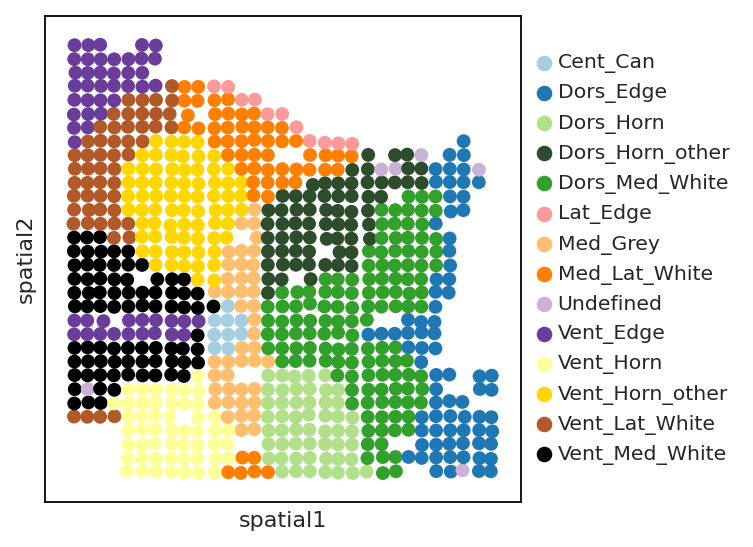

In [35]:
sc.pl.spatial(adata_c2, spot_size=1, color = ['anno_v2'], 
              vmin = 'p1', vmax = 'p99', title = '', 
              palette=c_pal_v2, outline_color= 'black',
             )

#### Calculate % of spots conserved between AARs

In [20]:
def percent_aar_conserved(adata_layer1, adata_layer2, alpha):
    adata_c1 = adata_layer1.copy()
    adata_c2 = adata_layer2.copy()
    pi = paste.pairwise_align(adata_c1, adata_c2, alpha=alpha)
    spotsA, spotsB = np.nonzero(pi)
    s = 0
    for i in range(len(spotsA)):
        # get the clusters corresponding to each spot
        a = adata_c1.obs['anno_v2'][spotsA[i]]
        b = adata_c2.obs['anno_v2'][spotsB[i]]
        if a == b:
            s += pi[spotsA[i]][spotsB[i]]
    return s

Simulate experiments

In [38]:
adata_c1, adata_c2 = read_in_data()

adata_c2_flip_vert = adata_c2.copy()
adata_c2_flip_vert.obsm['spatial'][:,1] *= -1

adata_c2_flip_horz = adata_c2.copy()
adata_c2_flip_horz.obsm['spatial'][:,0] *= -1

alphas = [0, 0.001, 0.01, 0.1, 1]
original_scores = []
horz_scores = []
vert_scores = []
for a in alphas:
    original_scores.append(percent_aar_conserved(adata_c1, adata_c2, a))
    horz_scores.append(percent_aar_conserved(adata_c1, adata_c2_flip_horz, a))
    vert_scores.append(percent_aar_conserved(adata_c1, adata_c2_flip_vert, a))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Combining duplicate genes


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Combining duplicate genes
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices for common genes. There are 16367 common genes.
Filtered all slices fo

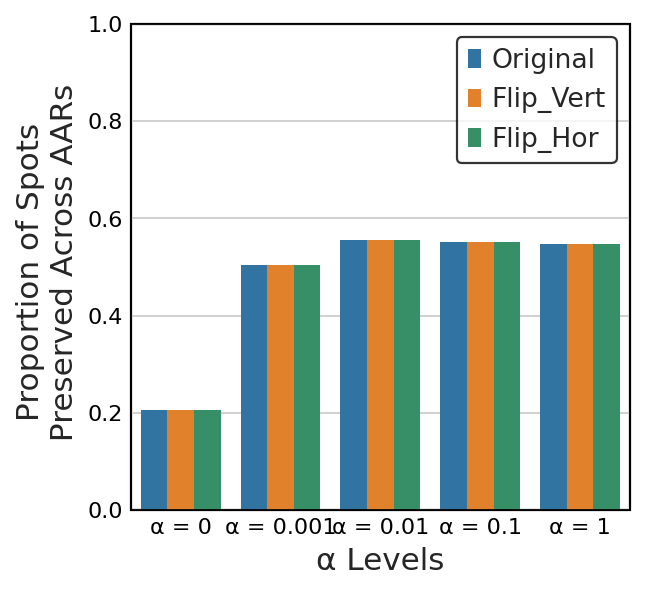

In [45]:
vals = []
for i in range(len(original_scores)):
    vals.append(original_scores[i])
    vals.append(vert_scores[i])
    vals.append(horz_scores[i])
    
colors = sns.color_palette()
bar_label = 5*['Original', 'Flip_Vert', 'Flip_Hor']
labels = 3*['α = 0'] + 3*['α = 0.001'] + 3*['α = 0.01'] +3*['α = 0.1'] + 3*['α = 1']

ax2 = sns.barplot(x=labels, y = vals, hue=bar_label, palette=sns.color_palette(colors))
ax2.set_facecolor('white')
ax2.patch.set_edgecolor('black')
ax2.patch.set_linewidth('1')
ax2.set(ylim = (0, 1))
ax2.set_ylabel("Proportion of Spots \n Preserved Across AARs", fontsize = 14)
ax2.set_xlabel("α Levels", fontsize = 14)
plt.legend(frameon=True, edgecolor='black', fontsize = 12)
# plt.savefig('spinal_pairwise_plot.pdf', dpi = 300, bbox_inches = "tight")

## Misc/Other Analysis

#### Plot projection of all AAR from layer 1 onto layer 2

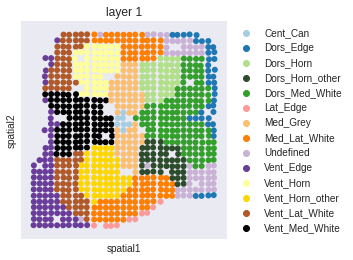

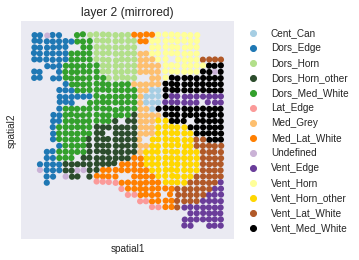

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


<ipython-input-13-4e1427e66f16>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_c2.obs['mapped'][j] = adata_c1.obs['anno_v2'][i]
... storing 'mapped' as categorical


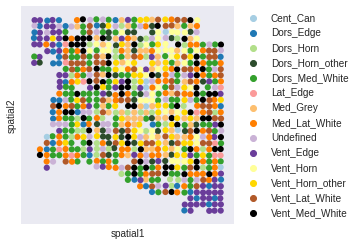

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


<ipython-input-13-4e1427e66f16>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_c2.obs['mapped'][j] = adata_c1.obs['anno_v2'][i]
... storing 'mapped' as categorical


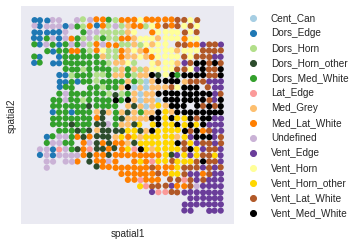

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


<ipython-input-13-4e1427e66f16>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_c2.obs['mapped'][j] = adata_c1.obs['anno_v2'][i]
... storing 'mapped' as categorical


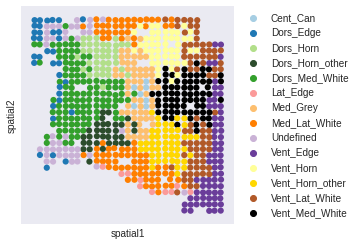

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


<ipython-input-13-4e1427e66f16>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_c2.obs['mapped'][j] = adata_c1.obs['anno_v2'][i]
... storing 'mapped' as categorical


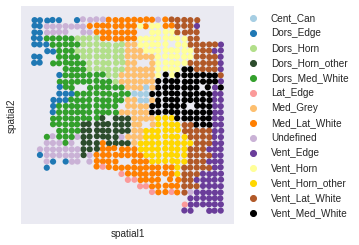

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


<ipython-input-13-4e1427e66f16>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_c2.obs['mapped'][j] = adata_c1.obs['anno_v2'][i]
... storing 'mapped' as categorical


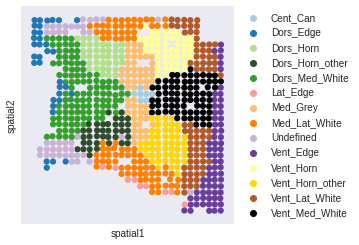

In [13]:
c_pal2 = c_pal 
c_pal2['bg'] = '#808080'

sc.pl.spatial(adata_c1, spot_size=1, color = ['anno_v2'], 
              vmin = 'p1', vmax = 'p99', title = 'layer 1', 
              palette=c_pal_v2, cmap= 'rocket_r', layer='zscore')
sc.pl.spatial(adata_c2, spot_size=1, color = ['anno_v2'], 
              vmin = 'p1', vmax = 'p99', title = 'layer 2 (mirrored)', 
              palette=c_pal_v2, cmap= 'rocket_r', layer='zscore')
all_scores = []
for a in [0, 0.001, 0.01, 0.1, 1]:
    a1 = adata_c1.copy()
    a2 = adata_c2.copy()
    pi = paste.pairwise_align(a1, a2, alpha=a)
    mapped_spots = []
    adata_c2.obs['mapped'] = 'bg'
    score = 0
    for j in range(pi.shape[1]):
        i = np.argmax(pi[:,j])
        adata_c2.obs['mapped'][j] = adata_c1.obs['anno_v2'][i]
        if (adata_c1.obs['anno_v2'][i] == adata_c2.obs['anno_v2'][j]):
            score += 1
    all_scores.append(score/adata_c2.shape[0])

    sc.pl.spatial(adata_c2, spot_size=1, color = ['mapped'], 
                  vmin = 'p1', vmax = 'p99', title = '', 
                  cmap= 'rocket_r', palette = c_pal_v2, 
                  # save = '_spinal_sliceB__horz_'+str(a)
                 )

In [126]:
aar_count_c1 = {}
for i in adata_c1.obs['anno_v2']:
    aar_count_c1[i] = aar_count_c1.get(i, 0) + 1
    
aar_count_c2 = {}
for i in adata_c2.obs['anno_v2']:
    aar_count_c2[i] = aar_count_c2.get(i, 0) + 1
    
for k in aar_count_c1.keys():
    aar_count_c1[k] = aar_count_c1[k]/adata_c1.shape[0]
    
for k in aar_count_c2.keys():
    aar_count_c2[k] = aar_count_c2[k]/adata_c2.shape[0]

In [127]:
count = 0
for k in aar_count_c2.keys():
    if k in aar_count_c1.keys():
        count += min(aar_count_c1[k], aar_count_c2[k])

print('Max % of AARs mapped: ' + str(count))

Max % of AARs mapped: 0.8288991859813313


#### Projection of layer 2 onto layer 1

... storing 'anno' as categorical
... storing 'anno_v2' as categorical


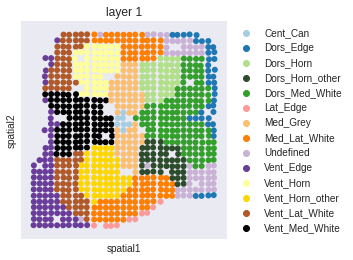

... storing 'anno' as categorical
... storing 'anno_v2' as categorical


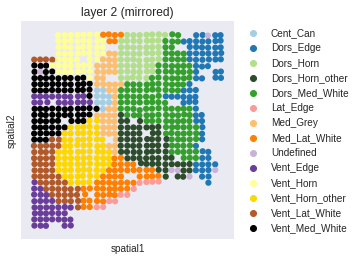

Filtered all slices for common genes. There are 16367 common genes.


<ipython-input-137-377de6f96ea5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_c1.obs['mapped'][i] = adata_c2.obs['anno_v2'][j]
... storing 'mapped' as categorical


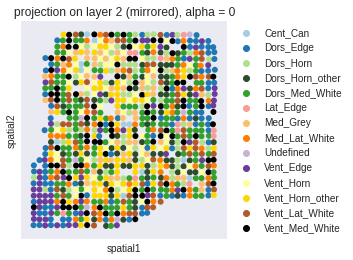

Filtered all slices for common genes. There are 16367 common genes.


... storing 'mapped' as categorical


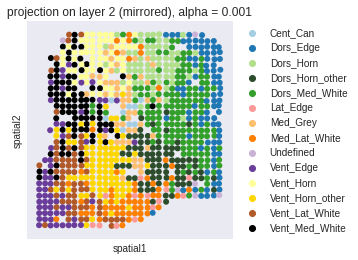

Filtered all slices for common genes. There are 16367 common genes.


... storing 'mapped' as categorical


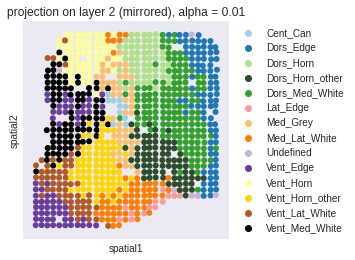

Filtered all slices for common genes. There are 16367 common genes.


... storing 'mapped' as categorical


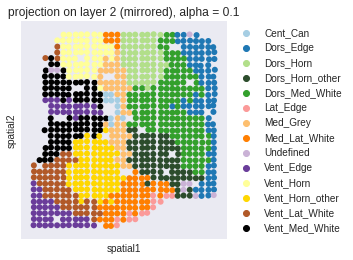

Filtered all slices for common genes. There are 16367 common genes.


... storing 'mapped' as categorical


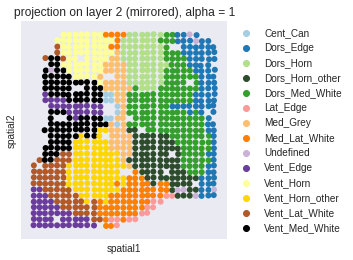

In [137]:
c_pal2 = c_pal 
c_pal2['bg'] = '#808080'

sc.pl.spatial(adata_c1, spot_size=1, color = ['anno_v2'], 
              vmin = 'p1', vmax = 'p99', title = 'layer 1', 
              palette=c_pal_v2, cmap= 'rocket_r', layer='zscore')
sc.pl.spatial(adata_c2, spot_size=1, color = ['anno_v2'], 
              vmin = 'p1', vmax = 'p99', title = 'layer 2 (mirrored)', 
              palette=c_pal_v2, cmap= 'rocket_r', layer='zscore')
s_flip_vert = []
for a in [0, 0.001, 0.01, 0.1, 1]:
    a1 = adata_c1.copy()
    a2 = adata_c2.copy()
    pi = paste.pairwise_align(a1, a2, alpha=a)
    mapped_spots = []
    adata_c1.obs['mapped'] = 'bg'
    score = 0
    for i in range(pi.shape[0]):
        j = np.argmax(pi[i,:])
        adata_c1.obs['mapped'][i] = adata_c2.obs['anno_v2'][j]
        if (adata_c1.obs['anno_v2'][i] == adata_c2.obs['anno_v2'][j]):
            score += 1
    s_flip_vert.append(score/adata_c1.shape[0])

    sc.pl.spatial(adata_c1, spot_size=1, color = ['mapped'], 
                  vmin = 'p1', vmax = 'p99', title = 'projection on layer 2 (mirrored), alpha = '  + str(a), 
                  cmap= 'rocket_r', palette = c_pal_v2, layer='zscore')

#### Plot projection of one AAR from layer 1 onto the layer 2

In [23]:
c_pal2 = c_pal 
c_pal2['bg'] = '#808080'

Filtered all slices for common genes. There are 16367 common genes.


... storing 'anno' as categorical


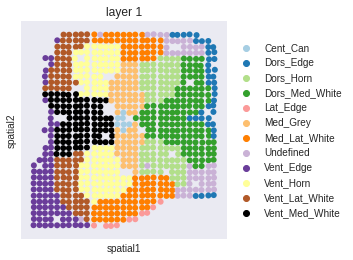

... storing 'anno' as categorical
... storing 'mapped' as categorical


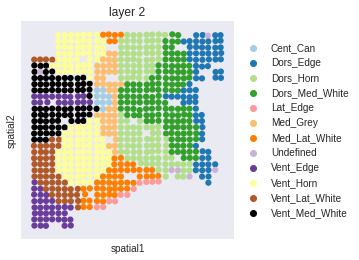

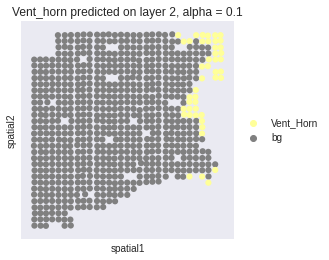

In [22]:
aar = 'Dors_Edge'
a = 0.1
a1 = adata_c1.copy()
a2 = adata_c2.copy()
pi = paste.pairwise_align(a1, a2, alpha=a)
idx = adata_c1.obs['anno'] == aar
idx = [i for i, x in enumerate(idx) if x]

spotsA, spotsB = np.nonzero(pi)
mapped_spots = []
for i in range(len(spotsA)):
    if spotsA[i] in idx:
        mapped_spots.append(spotsB[i])
adata_c2.obs['mapped'] = 'bg'
for i in mapped_spots:
    adata_c2.obs['mapped'][i] = aar

sc.pl.spatial(adata_c1, spot_size=1, color = ['anno'], 
              vmin = 'p1', vmax = 'p99', title = 'layer 1', 
              palette=c_pal, cmap= 'rocket_r', layer='zscore')
sc.pl.spatial(adata_c2, spot_size=1, color = ['anno'], 
              vmin = 'p1', vmax = 'p99', title = 'layer 2', 
              palette=c_pal, cmap= 'rocket_r', layer='zscore')
sc.pl.spatial(adata_c2, spot_size=1, color = ['mapped'], 
              vmin = 'p1', vmax = 'p99', title = aar  + ' predicted on layer 2, alpha = '  + str(a), 
              cmap= 'rocket_r', palette = c_pal2, layer='zscore')